# Whole brain data processing

### Denoise

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from cellProcessing import *
from fish_proc.utils.memory import get_process_memory, clear_variables

%matplotlib inline
%load_ext autoreload
%autoreload 2

## Set up environments

* Install `fish_proc` from github https://github.com/zqwei/fish_processing

In [2]:
## STEP 1: specify data and save path
dir_root = '/groups/ahrens/ahrenslab/jing/giving_up/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/im'
# save_root = '/nrs/ahrens/jing/20190219/fish2/7dpf-huc_gcamp7ff_gfap_rgeco-GU_slow_fwd-fish02-exp02_20190219_174013/processed'

### Set save folder to Ziqiang's folder

In [3]:
save_root = './processed'
if not os.path.exists(save_root):
    os.makedirs(save_root)

## Local PCA denoise in masked data

In [4]:
import zarr
import dask.array as da

In [5]:
from fbpca import diffsnorm, pca

In [6]:
from fish_proc.utils.snr import correlation_pnr

In [7]:
Y_d = da.from_zarr(f'{save_root}/detrend_data.zarr')
mask = da.from_zarr(f'{save_root}/mask_map.zarr')

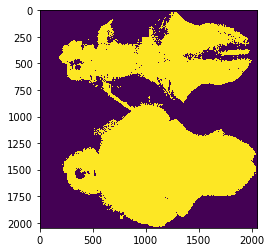

In [40]:
plt.imshow(mask[8].squeeze())

In [43]:
mask_ = mask.blocks[8, 6, 0, 0]
block = Y_d.blocks[8, 6, 0, 0]

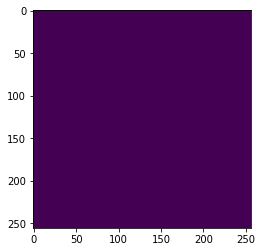

In [44]:
plt.imshow(mask_.squeeze())

In [45]:
get_process_memory()

RAM used 5.0222 GB


5.0222320556640625

In [46]:
M = (block-block.mean(axis=-1, keepdims=True)).squeeze().compute()
dimsM = M.shape
M = M.reshape((np.prod(dimsM[:-1]),dimsM[-1]),order='F')

In [49]:
k = min(min(M.shape)//4, 300)

In [50]:
%%time
[U, S, Va] = pca(M.T, k=k, n_iter=20, raw=True)

CPU times: user 10min 16s, sys: 6min 10s, total: 16min 26s
Wall time: 1min 2s


In [51]:
get_process_memory()

RAM used 6.4064 GB


6.4063873291015625

In [52]:
M_pca = U.dot(np.diag(S).dot(Va))

In [53]:
M_pca = M_pca.T.reshape(dimsM, order='F')

In [54]:
M = (block-block.mean(axis=-1, keepdims=True)).squeeze().compute()

In [55]:
Cn_, _ = correlation_pnr(M, skip_pnr=True)
Cn, _ = correlation_pnr(M_pca, skip_pnr=True)

Number of processes to parallel: 48
Number of processes to parallel: 48


In [56]:
thres = np.percentile(Cn, [99, 95, 80, 50])

In [57]:
thres

array([0.82299031, 0.7951124 , 0.76023448, 0.73693636])

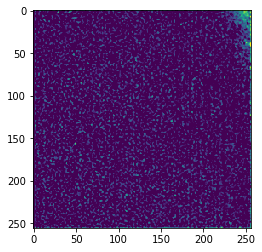

In [68]:
plt.imshow(Cn_, vmin=0.6, vmax=0.66)

In [62]:
Cn_.max()

0.6673288658293137

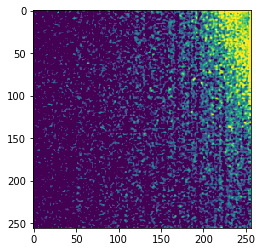

In [64]:
plt.imshow(Cn, vmin=thres[-1], vmax=thres[0])

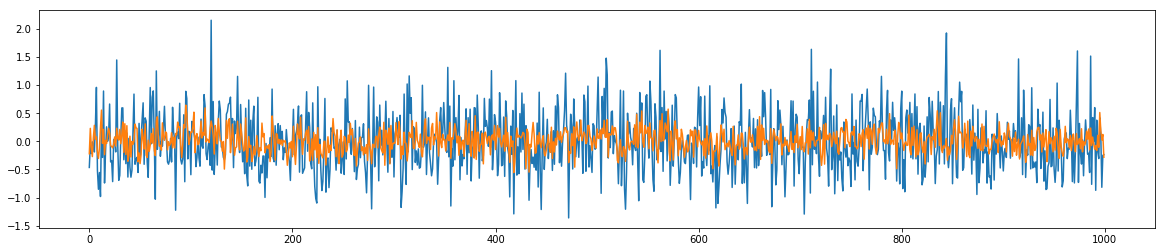

In [59]:
plt.figure(figsize=(20, 4))
plt.plot(M[128, 128][:1000])
plt.plot(M_pca[128, 128][:1000])